# Project Background - Wine Reviews

This project, and the data used, is based on the dataset called "Wine Reviews" listed on [Kaggle](https://www.kaggle.com/zynicide/wine-reviews/home). 

The dataset contains 14 columns and 130,000 rows of wine reviews and was scraped from [WineEnthusiast](https://www.winemag.com/?s=&drink_type=wine) by Kaggler [zackthoutt](https://www.kaggle.com/zynicide) who is interested in "creating a model that can identify variety, winery, and location of a wine based on a description." 

## First Impressions
I want to see if it's possible to predict the points of a wine given a set of inputs (price, designation, country of orgin, etc). I'm thinking the description might be useful if I do some sort of unsupervised learning or something on it. There isn't much continuous data. 

## Data Discussion

The dataset contains 14 columns:
* '# Number
* Country: The country that the wine is from
* Description: A few sentences form a sommelier describing the wine's taste, smell, look, feel, etc.
* Designation: The vineyard within the winery where the grapes that made the wine are from. 
* Points: the number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews of wines that score greater than 80).
* Price: The cost for a bottle of wine
* Provice: The state or provice that the wine is from
* Region_1: The growing area in a provice or state 
* Region_2: Sometimes there are more specific regions specific within a wine growing area (can contain NULL Values)
* Taster_name: Name of the person who tasted and reviewed the wine. 
* Taster_twitter_handle: Twitter handle for the person who tasted and reviewed the wine
* Title: The title of the wine review, which often contains the vintage if you're interested in extracted that feature
* Variety: The type of grapes used to make the win (i.e. Pinot Noir)



### Import Libraries

In [2]:
# I like to stash the imports at the top so readers know what dependencies exist
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from nltk.corpus import stopwords

#You Might need to run the two lines below for nltk
#import nltk
#nltk.download('stopwords')

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

## Userful Functions
Some Functions I created to clean up some of the code later on

In [3]:
# Simple Function to Find What Data is Missing 
# Input = Some Data
# Transformation = Find the total number of missing Values
# Return Missing Data as a Total Number and as a Percent of The Input
def missingData (data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    return missing_data

#Bin the points using the standard deviation = 3
def transform_points_simplified(points):
    if points < 84:
        return 1 #low quality wine
    elif points >= 84 and points < 88:
        return 2 #low-medium quality wine
    elif points >= 88 and points < 92:
        return 3 #medium quality wine
    elif points >= 92 and points < 96:
        return 4 #medium-high quality wine
    else:
        return 5 #the finest of wines

#### Read in the data

In [4]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### Thoughts
Because the points is something I want to predict, I'm going to move it to the end of the DataFrame to make my life easier

In [5]:
X = df.iloc[:,[0,1,2,3,5,6,7,8,9,10,11,12,13]]
y = df.iloc[:,[4]].values

df_x = pd.DataFrame(X)
df_y = pd.DataFrame(y, columns = ['points'])

df = pd.concat([df_x,df_y], axis = 1)
df.head(5)

,Unnamed: 0,country,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,87
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,87
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,87
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,87
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,87


## Data Cleansing

#### Check for Duplicate Data
I want to check for duplicate data -- most likely get rid of it considering this was scraped from a website it might not be clean. I'll check by "Description" because this would be the most unique

In [6]:
df[df.duplicated('description', keep = False)].sort_values('description')

,Unnamed: 0,country,description,designation,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,points
67614,67614,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge,87
46540,46540,US,"100% Malbec, it's redolent with dark plums, wi...",NaN,20.0,Washington,Rattlesnake Hills,Columbia Valley,Sean P. Sullivan,@wawinereport,Roza Ridge 2010 Malbec (Rattlesnake Hills),Malbec,Roza Ridge,87
119702,119702,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew,88
72181,72181,US,"100% Sangiovese, this pale pink wine has notes...",Meadow,18.0,Washington,Columbia Valley (WA),Columbia Valley,Sean P. Sullivan,@wawinereport,Ross Andrew 2013 Meadow Rosé (Columbia Valley ...,Rosé,Ross Andrew,88
73731,73731,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie,88
100745,100745,France,"87-89 Barrel sample. A pleasurable, perfumed w...",Barrel sample,NaN,Bordeaux,Saint-Julien,NaN,Roger Voss,@vossroger,Château Lalande-Borie 2008 Barrel sample (Sai...,Bordeaux-style Red Blend,Château Lalande-Borie,88
73730,73730,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe,88
100744,100744,France,87-89 Barrel sample. Minty aromas give lifted ...,Barrel sample,NaN,Bordeaux,Saint-Émilion,NaN,Roger Voss,@vossroger,Château Haut-Sarpe 2008 Barrel sample (Saint-...,Bordeaux-style Red Blend,Château Haut-Sarpe,88
73729,73729,France,87-89 Barrel sample. With its lovely fresh fru...,Barrel sample,NaN,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,@vossroger,Château Bertineau Saint-Vincent 2008 Barrel sa...,Bordeaux-style Red Blend,Château Bertineau Saint-Vincent,88
100743,100743,France,87-89 Barrel sample. With its lovely fresh fru...,Barrel sample,NaN,Bordeaux,Lalande de Pomerol,NaN,Roger Voss,@vossroger,Château Bertineau Saint-Vincent 2008 Barrel sa...,Bordeaux-style Red Blend,Château Bertineau Saint-Vincent,88


In [7]:
df = df.drop_duplicates('description')
df.shape

(119955, 14)

Leaves us with about 120k rows of data

#### Check for NULL Values
I'm also thinking we should see what values are 'NaN' -- Either I'll drop them or impute the data depending on what the feature is. 


In [8]:
print(df.shape)
missingData(df)

(119955, 14)


,Total,Percent
region_2,73195,61.018715
designation,34532,28.787462
taster_twitter_handle,29441,24.543370
taster_name,24912,20.767788
region_1,19558,16.304448
price,8388,6.992622
province,59,0.049185
country,59,0.049185
variety,1,0.000834
points,0,0.000000


#### Thoughts
I'm not too concerned about region_2. I looked into the data and this is more of an optional descriptor. Additionally, I'm not going to worry about the missing twitter handle or twitter name fields for now. Once I get into Feature Engineering, I'll determine if those are useful or not. 

*price:* I do need to take care of the missing "price" data. That'll most likely be something we use but I would like to do some EDA first. I'm leaning towards just dropping it but let's do some visualization first. If my results are too good, I'll use the missing prices values to regularlize the dataset. 

*province & country:* I would naturally think these values are important. Things like tarrifs, fixed & variable costs being greater at smaller wineries, and taxes all add to the cost of the wine. I'm going to drop these missing values. I could cross reference province and country but it seems like they're both missing for every record. There's only 59 records so not a big deal. 

*variety:* 1 record missing. I'll drop that too.

I can probably drop that Unnamed column too.

In [9]:
df = df.drop(columns=['Unnamed: 0'])
df = df.reset_index(drop=True)

df = df.dropna(subset=['province'])
df = df.reset_index(drop=True)

df = df.dropna(subset=['country'])
df = df.reset_index(drop=True)

df = df.dropna(subset=['variety'])
df = df.reset_index(drop=True)

## Exploratory Data Analysis (EDA)
Let's have a look at the statistics of the DataFrame

In [10]:
df.describe()

,price,points
count,111511.000000,119895.000000
mean,35.626073,88.442204
std,42.116495,3.093401
min,4.000000,80.000000
25%,17.000000,86.000000
50%,25.000000,88.000000
75%,42.000000,91.000000
max,3300.000000,100.000000


#### Thoughts
The two features we can get statistics on are Points and Price (being that they're continuous values). 

*Points:* Looks like the mean and mediun are roughly the same. The are only between 80-100. I looked into this and the website doesn't post reviews of wines that score less than 80 points.

*Price:* We have a wine that costs $3300. That's definately some walking around money! The standard deviation seems kind of large. Might want to look deeper into this and see if there's more high priced wines skewing this. Referring back to above, About 7 percent of the data is a missing price. I think i'm just going to drop these values for now. I'm more concerned about seeing the price distribution.



In [11]:
# Drop the NaN Prices
df=df.dropna(subset=['price'])
df=df.reset_index(drop=True)
print(df.shape)
missingData(df)

(111511, 13)


,Total,Percent
region_2,64952,58.247168
designation,32039,28.731695
taster_twitter_handle,27750,24.885437
taster_name,23267,20.865206
region_1,17955,16.101551
points,0,0.000000
winery,0,0.000000
variety,0,0.000000
title,0,0.000000
province,0,0.000000


#### Distribution of Price
Because we know points has a relatively normal distrubtion we don't really need to visualize that, but price is probably skewed with some fancy/expensive wines so let's try to visualize the distribution. 


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


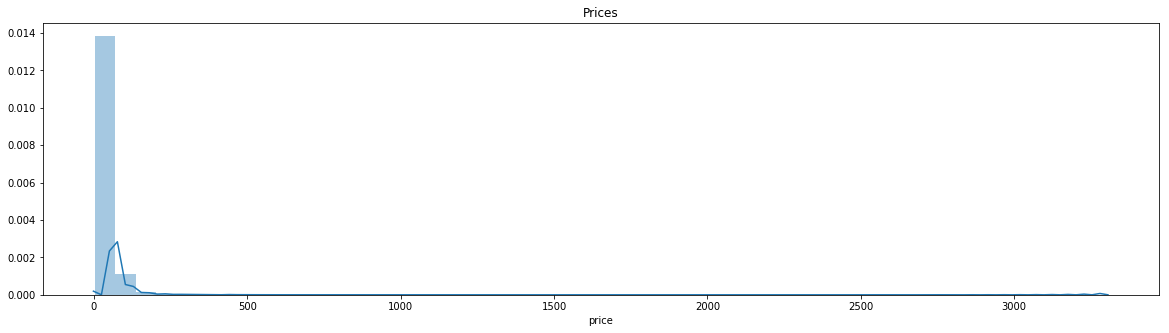

In [12]:
plt.figure(figsize=(20,5))
plt.title("Prices")
x = sns.distplot(df['price'])


#### Thoughts
There aren't too many expensive wines but they're definately skewing things. Let's see which ones we can get rid of while we're looking at it. Let's loop through a few calculations to find a sweet spot and drop the expensive wines.

In [13]:
x = 95
while (x < 350):
    percent = df[df['price']>x].shape[0]/df.shape[0]*100
    print(percent, "% of wines are more expensive than ", "$",x,)
    x = x + 10
    
    

3.558393342360843 % of wines are more expensive than  $ 95
2.7154271775878613 % of wines are more expensive than  $ 105
2.32712467828286 % of wines are more expensive than  $ 115
1.7648483109289668 % of wines are more expensive than  $ 125
1.4994036462770488 % of wines are more expensive than  $ 135
1.3021136928195425 % of wines are more expensive than  $ 145
1.0277013030104654 % of wines are more expensive than  $ 155
0.9281595537659961 % of wines are more expensive than  $ 165
0.7981275389871851 % of wines are more expensive than  $ 175
0.741630870497081 % of wines are more expensive than  $ 185
0.6896180645855566 % of wines are more expensive than  $ 195
0.5918698603725193 % of wines are more expensive than  $ 205
0.5595860498067455 % of wines are more expensive than  $ 215
0.5066764713795051 % of wines are more expensive than  $ 225
0.4761862058451633 % of wines are more expensive than  $ 235
0.4483862578579692 % of wines are more expensive than  $ 245
0.38919927182071723 % of wine

#### Thoughts
I'm thinking the sweet spot will be around 255 dollars. With only 0.3890 percent of the wines being greater than 255, we can drop this and see what we have. 

In [14]:
df = df[df.price < 255]
df=df.reset_index(drop=True)
print(df.shape)
missingData(df)

(111071, 13)


,Total,Percent
region_2,64552,58.117781
designation,31877,28.699661
taster_twitter_handle,27675,24.916495
taster_name,23215,20.901045
region_1,17886,16.103213
points,0,0.000000
winery,0,0.000000
variety,0,0.000000
title,0,0.000000
province,0,0.000000


(111071, 13)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


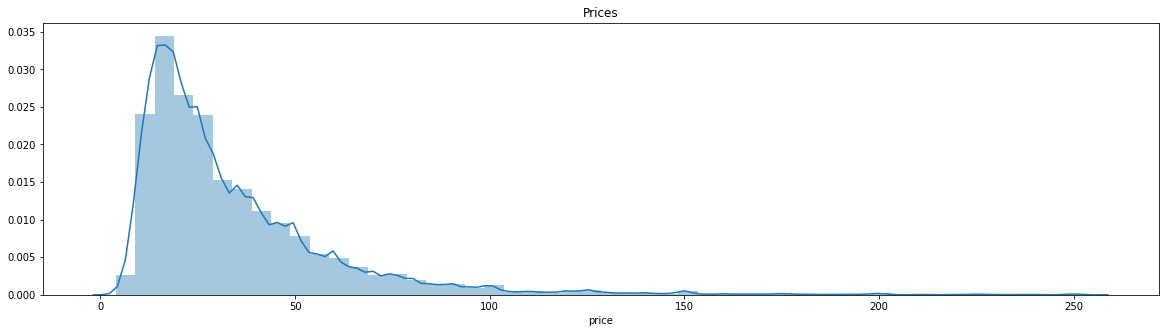

In [15]:
print(df.shape)
plt.figure(figsize=(20,5))
plt.title("Prices")
x = sns.distplot(df['price'])

In [16]:
df.describe()

,price,points
count,111071.000000,111071.000000
mean,33.960683,88.388787
std,26.557020,3.075890
min,4.000000,80.000000
25%,17.000000,86.000000
50%,25.000000,88.000000
75%,42.000000,91.000000
max,253.000000,100.000000


#### Thoughts 
The mean and medium for price are now a little bit tighter and the standard deviation came down, this'll probably help us get more accurate results now that we don't have any outliers. Might still be a good idea to use a scaler

#### Visualizing price and points by  the top 20 Counties

In [17]:
top = df.groupby(['country'])['price','points'].mean().reset_index().sort_values('price', ascending=False)
top20 = top[['country','points','price']].head(n=20)
top20

,country,points,price
37,Switzerland,88.500000,72.833333
13,England,91.762712,52.677966
21,Italy,88.609840,38.435989
39,US,88.552910,36.398673
16,Germany,89.790078,36.071540
7,Canada,89.312500,35.776786
14,France,88.657009,35.539813
18,Hungary,89.174603,34.301587
2,Australia,88.533364,33.111214
20,Israel,88.470199,31.770419


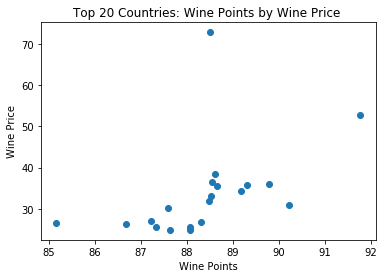

In [18]:
plot = plt.scatter(top20.iloc[:,1], top20.iloc[:,2])
plt.title("Top 20 Countries: Wine Points by Wine Price ")
plt.xlabel('Wine Points')
plt.ylabel('Wine Price')
plt.show()
plt.close()

#### Looks like there's some correlation between price and points

#### Variety of Wines
I was looking through the raw data and there seems to be a wide variety of wines. Let's have a look.

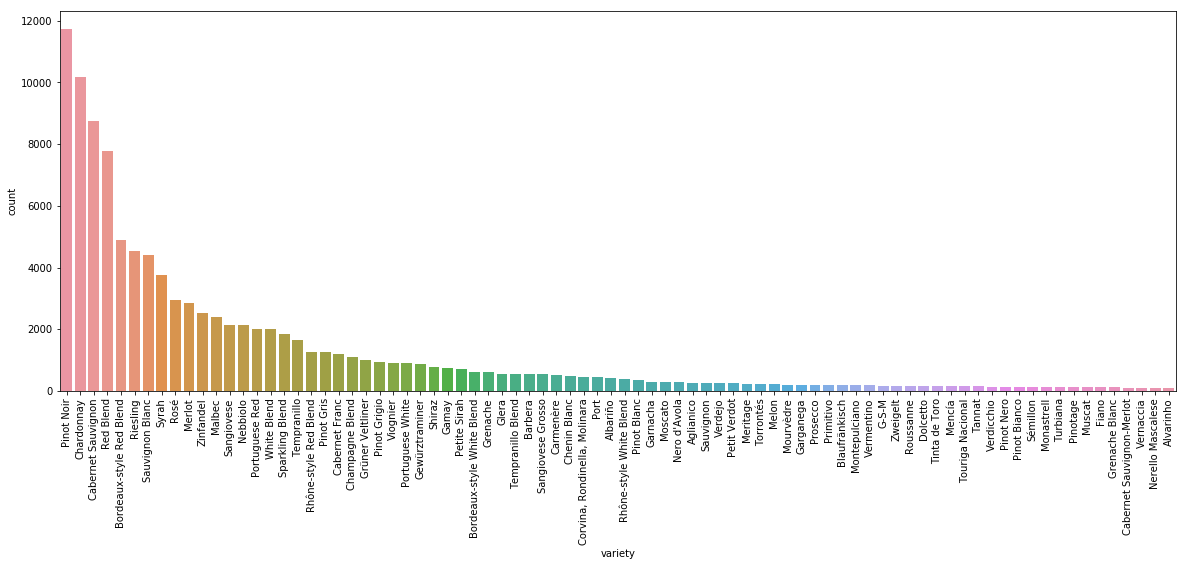

In [19]:
data = df.groupby('variety').filter(lambda x: len(x) >100)
list = data.variety.value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(x='variety', data=data, order = list, ax = ax)
plt.xticks(rotation = 90)
plt.show()

#### Thoughts
It looks like there's a lot of wines here from all sorts of languages and cultures. I would have to do some research or find a way to translate. Wines like "pinot nero" are probably a pinot noir. Safe bet would be to pick the wines varieties with lots of observations. Looks like 1500 would be a good cut off point

#### Create variety_df : Where observations > 1500

In [20]:
variety_df = df.groupby('variety').filter(lambda x: len(x) > 1500)
varieties = variety_df['variety'].value_counts().index.tolist()

print(variety_df.shape)
variety_df['variety'].unique()


(78536, 13)


array(['Portuguese Red', 'Riesling', 'Pinot Noir', 'Cabernet Sauvignon',
       'Chardonnay', 'Malbec', 'Red Blend', 'White Blend', 'Merlot',
       'Sauvignon Blanc', 'Sangiovese', 'Bordeaux-style Red Blend',
       'Rosé', 'Zinfandel', 'Syrah', 'Nebbiolo', 'Sparkling Blend',
       'Tempranillo'], dtype=object)

#### Thoughts
This gives us about 15 wines to play with. I think I'm going to hold onto variety_df and use it going forward 

#### Visualizing Country Data

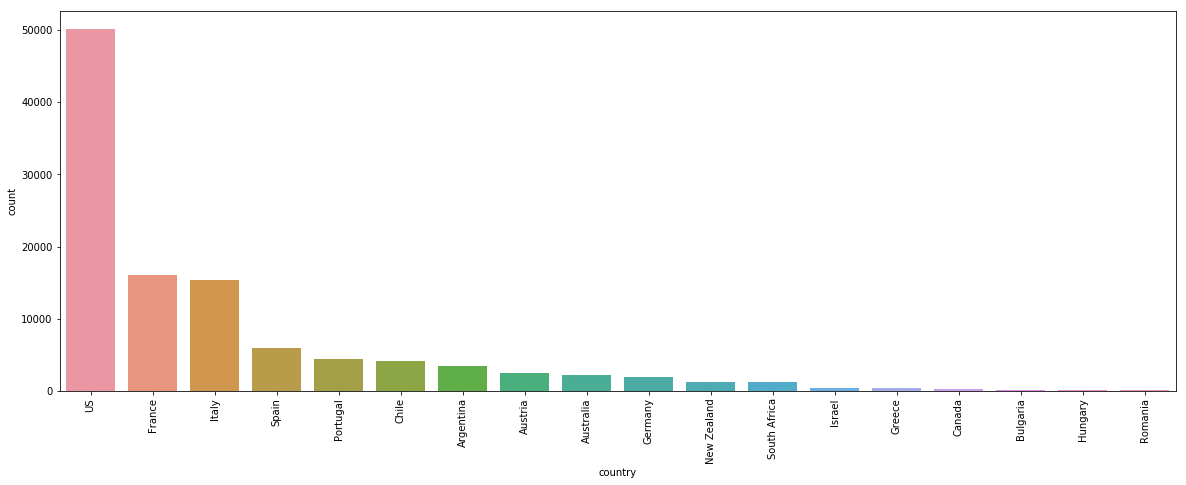

In [21]:
data = df.groupby('country').filter(lambda x: len(x) >100)
list = data.country.value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (20,7))
sns.countplot(x='country', data=data, order = list, ax = ax)
plt.xticks(rotation = 90)
plt.show()

## Hypothesis Test, Feature Engineering & Model Selection

### Hypothesis

* H0: There is no predictive value in the description of a wine and the amount of points it recieves
* H1: There is predictive value in the description and the points a wine recieves

### Feature Engineering

#### Create a New DataFrame using selected Features where the variety > 1500 observations

In [22]:
data = variety_df[['country','price', 'description','points']]
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78536 entries, 0 to 111067
Data columns (total 4 columns):
country        78536 non-null object
price          78536 non-null float64
description    78536 non-null object
points         78536 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.0+ MB


,country,price,description,points
0,Portugal,15.0,"This is ripe and fruity, a wine that is smooth...",87
2,US,13.0,"Pineapple rind, lemon pith and orange blossom ...",87
3,US,65.0,"Much like the regular bottling from 2012, this...",87
9,US,19.0,"Soft, supple plum envelopes an oaky structure ...",87
11,US,34.0,"Slightly reduced, this wine offers a chalky, t...",87


#### Create a Simpler Points System
The points range from 80 - 100, however, I'm sure if you tasted a wine, let's say a merlot, rated at 87 and another merlot rated at 88, you wouldn't be able to taste the difference. Let's bin them using the standard deviation = 3

In [24]:
#Apply the transformation from our function 'transform_points_simplified'
data = data.assign(points_simplified = data['points'].apply(transform_points_simplified))
data.head()

,country,price,description,points,points_simplified
0,Portugal,15.0,"This is ripe and fruity, a wine that is smooth...",87,2
2,US,13.0,"Pineapple rind, lemon pith and orange blossom ...",87,2
3,US,65.0,"Much like the regular bottling from 2012, this...",87,2
9,US,19.0,"Soft, supple plum envelopes an oaky structure ...",87,2
11,US,34.0,"Slightly reduced, this wine offers a chalky, t...",87,2


## Model Selection
I'm going to perform a tf-idf on the description and see if we can predict the points_simplified using Random Forsts

### tf-idf Model Implementation

In [27]:
import nltk
nltk.download('stopwords')

punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%",]
stop = set(stopwords.words('english'))
stop.update(punc)

desc = data['description'].values
tfidf = TfidfVectorizer(stop_words = stop, token_pattern = u'(?ui)\\b\\w*[a-z]+\\w*\\b')

#Above, I used regex to adjust the default token_pattern. Basically, I'm making sure the string pattern matches
#a word and contains at least one letter.

X = tfidf.fit_transform(desc)

words = tfidf.get_feature_names()

print(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jeremybrien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['05s', '06s', '07s', '08s', '09s', '100ml', '100th', '107th', '10g', '10th', '11th', '12g', '12th', '130th', '13g', '13th', '14g', '14th', '1500s', '150th', '155g', '159g', '15g', '15s', '15th', '160g', '16g', '16th', '1700s', '170g', '17th', '1800s', '1820s', '1840s', '1850s', '1860s', '187ml', '1880s', '188th', '1890s', '189g', '18th', '1920s', '1930s', '1950s', '1960s', '1970s', '1980s', '1990s', '1998s', '19th', '1st', '1ère', '2000s', '2004s', '2005s', '2006s', '2007s', '2008s', '2009s', '2010s', '2011s', '2012s', '2013s', '2014s', '2015s', '2020s', '20g', '20th', '21st', '22g', '23g', '24g', '25g', '25th', '26g', '2a', '2cv', '2g', '2l', '30g', '30th', '33rd', '34th', '35th', '375ml', '3bb', '3l', '3rd', '40th', '41st', '45g', '47g', '4g', '500l', '500th', '50g', '50th', '54g', '5g', '60th', '6g', '6th', '70g', '70s', '7th', '7up', '

#### Thoughts
Looks like some numbers are still coming through. This will probably hurt the model

//ToDo: remove any numbers in the feature_names


In [28]:
y = data['points_simplified']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 43)

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)

ct = pd.crosstab(y_test,predictions)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[ 124  417   60    2    0]
 [  66 2689 1327   36    0]
 [   5 1301 3283  319    0]
 [   1  145 1406  529    0]
 [   0    2   38   31    0]]
             precision    recall  f1-score   support

          1       0.63      0.21      0.31       603
          2       0.59      0.65      0.62      4118
          3       0.54      0.67      0.60      4908
          4       0.58      0.25      0.35      2081
          5       0.00      0.00      0.00        71

avg / total       0.56      0.56      0.54     11781



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Thoughts
In this case, I would fail to reject the H0. Without checking any test statistics, I can already tell the model is doing slightly better than guessing looking at the accuracies of classification report and confusion matrix. 

## Project Synopsis

*Short Comings:* I'm thinking tf-idf might be too complex or I didn't implement it correctly. I was having issues with removing numbers in the description. Using regex, I was able to remove some of the numbers appearing in the description string, however, numbers with a letter in the string kept appearing. I need to research this and probably look at Tokenization and custom "topics." 

*Future Models:* Looking over my EDA, I would like to go back and just try a simple linear regression on price and points. Additionally, I would consider doing a KNN with the simplified points or a linear regression. I could also adapt my model to see if we can predict the variety of wine using tf-idf and some type of supervised learning like I did with RFC. I would have to include the "variety" as a stop-word so It could be another project to get better at language processing. 

*A Promising Start:* I think if I had more time or someone a little more experienced with NLP this model could be powerful enough to get some accurate prediction against variety. Maybe not so much with points or a simplified version of the points. 

## Conclusion & Further Development

*As a Whole: * I had fun with this projects. I was able to find some fun examples of EDA and implement it (some of the distribution graphs). The results are slightly better than guessing -- I'll probably work on it a little bit more after finals are over to see if it can be improved, however, I expect I'll re-implement it using a different target variable (variety). 

*Considerations:* This model could be worth developing further. A recommender system could put in place based on user search terms (it could be branded as the "iSommlier" or something). I think it'd be something worth developing.

*Lasting Impressions:* There were a few points where I felt stuck or didn't know where to start because there weren't many continuous variables to use. This took me out of my comfort zone a bit as I am more familiar with logistic and linear regression problems. I enjoyed the project and plan on working on this, and others, a bit more using the tools and techniques we learned in class. 